In [1]:
# !pip install gdown pyarrow numpy seaborn matplotlib
# !gdown --folder "https://drive.google.com/drive/folders/14_aiMxHbjvUUJWs6XuT5of1Qd_iPWs-y" -O ../dataset/bank_data
# !unzip -o "../dataset/bank_data/case 1.zip" -d ../dataset/bank_data

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
# Pandas set up
pd.set_option('display.max_columns', None)

# Matplotlib set up
plt.rcParams.update({
    "font.size": 14,          # default text size
    "axes.titlesize": 16,     # title size
    "axes.labelsize": 14,     # x and y labels
    "xtick.labelsize": 12,    # x tick labels
    "ytick.labelsize": 12,    # y tick labels
    "legend.fontsize": 12,    # legend
})

In [4]:
# Create dict for each type of data
transfers = []
transactions = []

# Saving all csv files in respective lists
transfers_files = glob.glob('../dataset/bank_data/case 1/*transfers*.csv')
transactions_files = glob.glob('../dataset/bank_data/case 1/*transactions*.csv')

# Looping over the files and appending to the lists
for file in transfers_files:
    df = pd.read_csv(file)
    transfers.append(df)

for file in transactions_files:
    df = pd.read_csv(file)
    transactions.append(df)

# Merging all dataframes in the lists into single dataframes    
transfers_df = pd.concat(transfers, ignore_index=True)
transactions_df = pd.concat(transactions, ignore_index=True) 
clients_df = pd.read_csv('../dataset/bank_data/case 1/clients.csv')

# Sanity check

In [5]:
transfers_df['currency'].unique()

array(['KZT'], dtype=object)

In [6]:
transactions_df['currency'].unique()

array(['KZT', 'EUR'], dtype=object)

In [7]:
def convert_currency(transactions, rates=None):
    """
    Convert all transaction amounts to KZT using a rates dict.
    
    Parameters:
        transactions (pd.DataFrame): transactions DataFrame
        rates (dict): mapping of {currency: rate_to_KZT}
                      Example: {"EUR": 634, "USD": 470, "RUB": 5.3}
    """
    if rates is None:
        rates = {"EUR": 634, "USD": 470, "RUB": 5.3}  # default example rates

    for cur, rate in rates.items():
        mask = transactions["currency"] == cur
        transactions.loc[mask, "amount"] = transactions.loc[mask, "amount"] * rate
        transactions.loc[mask, "currency"] = "KZT"
    
    return transactions

transactions_df = convert_currency(
    transactions_df,
    rates={"EUR": 634, "USD": 470, "RUB": 5.3}
)

In [8]:
transactions_df['currency'].unique()

array(['KZT'], dtype=object)

In [9]:
print("=== Transactions ===")
print(transactions_df.info())
print(transactions_df.head())

print("\n=== Transfers ===")
print(transfers_df.info())
print(transfers_df.head())

print("\n=== Clients ===")
print(clients_df.info())
print(clients_df.head())

print("Unique clients (transactions):", transactions_df['client_code'].nunique())
print("Unique clients (transfers):", transfers_df['client_code'].nunique())
print("Unique clients (clients):", clients_df['client_code'].nunique())

=== Transactions ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_code  18000 non-null  int64  
 1   name         18000 non-null  object 
 2   product      18000 non-null  object 
 3   status       18000 non-null  object 
 4   city         18000 non-null  object 
 5   date         18000 non-null  object 
 6   category     18000 non-null  object 
 7   amount       18000 non-null  float64
 8   currency     18000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.2+ MB
None
   client_code    name            product status              city  \
0           10  Карина  Премиальная карта     зп  Усть-Каменогорск   
1           10  Карина  Премиальная карта     зп  Усть-Каменогорск   
2           10  Карина  Премиальная карта     зп  Усть-Каменогорск   
3           10  Карина  Премиальная карта     зп  Усть-Каменог

# Change types

In [10]:
# Transactions
transactions_df = transactions_df.astype({
    "client_code": "int64",
    "name": "string",
    "product": "category",
    "status": "category",
    "city": "category",
    "category": "category",
    "currency": "category"
})
transactions_df["date"] = pd.to_datetime(transactions_df["date"], errors="coerce")

# Transfers
transfers_df = transfers_df.astype({
    "client_code": "int64",
    "name": "string",
    "product": "category",
    "status": "category",
    "city": "category",
    "type": "category",
    "direction": "category",
    "currency": "category"
})
transfers_df["date"] = pd.to_datetime(transfers_df["date"], errors="coerce")


clients_df = clients_df.astype({
    "client_code": "int64",
    "name": "string",
    "status": "category",
    "age": "int64",
    "city": "category",
    "avg_monthly_balance_KZT": "int64"
})

In [11]:
months = 3
spend_by_category = transactions_df.groupby(["client_code", "category"])["amount"].sum().div(months).unstack(fill_value=0)
total_spend = transactions_df.groupby("client_code")["amount"].sum().div(months).rename("total_spend")
transactions_counts = transactions_df.groupby("client_code")["amount"].count().rename("n_transactions")
top3_categories = (transactions_df.groupby(["client_code", "category"])["amount"].sum().div(months)
             .reset_index()
             .sort_values(["client_code", "amount"], ascending=[True, False])
             .groupby("client_code")
             .head(3)
             .groupby("client_code")["category"].apply(list).rename("top3_categories"))

/tmp/ipykernel_228214/3162932.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spend_by_category = transactions_df.groupby(["client_code", "category"])["amount"].sum().div(months).unstack(fill_value=0)
/tmp/ipykernel_228214/3162932.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top3_categories = (transactions_df.groupby(["client_code", "category"])["amount"].sum().div(months)


In [12]:
# --- Transfers aggregation ---
in_out = transfers_df.groupby(["client_code", "direction"])["amount"].sum().div(months).unstack(fill_value=0)
in_out["net_in"] = in_out.get("in", 0) - in_out.get("out", 0)

# sum by type
type_sums = transfers_df.groupby(["client_code", "type"])["amount"].sum().div(months).unstack(fill_value=0)

/tmp/ipykernel_228214/2307048697.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  in_out = transfers_df.groupby(["client_code", "direction"])["amount"].sum().div(months).unstack(fill_value=0)
/tmp/ipykernel_228214/2307048697.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_sums = transfers_df.groupby(["client_code", "type"])["amount"].sum().div(months).unstack(fill_value=0)


In [13]:
# --- Clean intermediate aggregations ---
# make sure they don’t carry profile columns
transactions_counts = transactions_counts.reset_index()
spend_by_category   = spend_by_category.reset_index()
top3_categories     = top3_categories.reset_index()
in_out              = in_out.reset_index()
type_sums           = type_sums.reset_index()

# --- Merge everything ---
agg_df = (clients_df
          .merge(transactions_counts, on='client_code', how='left')
          .merge(spend_by_category,   on='client_code', how='left')
          .merge(top3_categories,     on='client_code', how='left')
          .merge(in_out,              on='client_code', how='left')
          .merge(type_sums,           on='client_code', how='left')
)

In [14]:
print("\n=== Agg ===")
print(agg_df.info())
print(agg_df.head())


=== Agg ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   client_code              60 non-null     int64   
 1   name                     60 non-null     string  
 2   status                   60 non-null     category
 3   age                      60 non-null     int64   
 4   city                     60 non-null     category
 5   avg_monthly_balance_KZT  60 non-null     int64   
 6   n_transactions           60 non-null     int64   
 7   АЗС                      60 non-null     float64 
 8   Авто                     60 non-null     float64 
 9   Едим дома                60 non-null     float64 
 10  Играем дома              60 non-null     float64 
 11  Кафе и рестораны         60 non-null     float64 
 12  Кино                     60 non-null     float64 
 13  Косметика и Парфюмерия   60 non-null     float64 
 14 

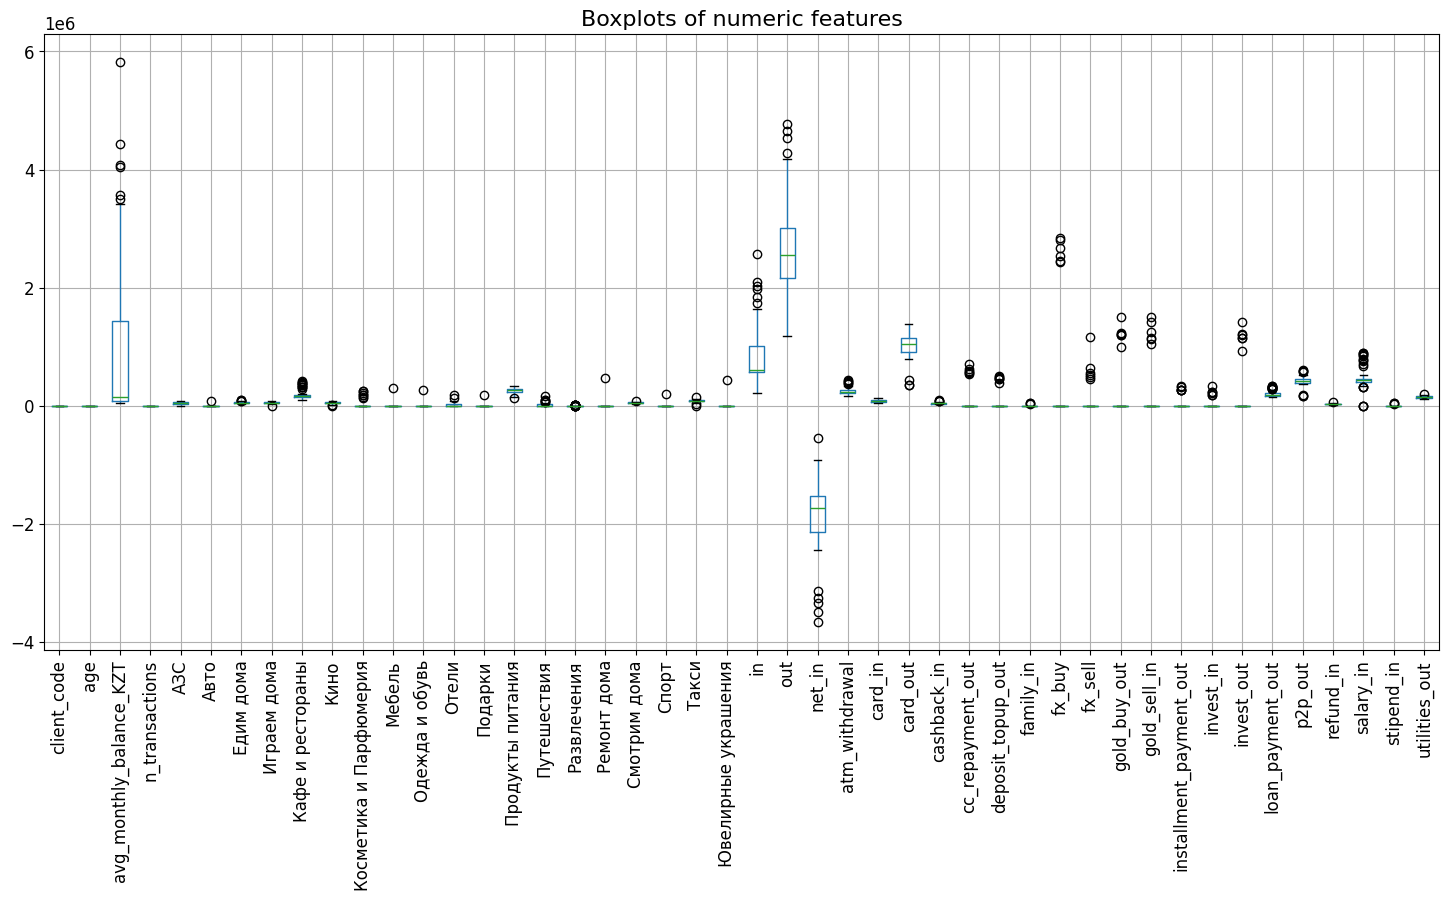

In [15]:
plt.figure(figsize=(18, 8))

numeric_cols = agg_df.select_dtypes(include=["int64", "float64"]).columns

agg_df[numeric_cols].boxplot(rot=90)
plt.title("Boxplots of numeric features")
plt.show()

In [16]:
agg_df

,client_code,name,status,age,city,avg_monthly_balance_KZT,n_transactions,АЗС,Авто,Едим дома,Играем дома,Кафе и рестораны,Кино,Косметика и Парфюмерия,Мебель,Одежда и обувь,Отели,Подарки,Продукты питания,Путешествия,Развлечения,Ремонт дома,Смотрим дома,Спорт,Такси,Ювелирные украшения,top3_categories,in,out,net_in,atm_withdrawal,card_in,card_out,cashback_in,cc_repayment_out,deposit_topup_out,family_in,fx_buy,fx_sell,gold_buy_out,gold_sell_in,installment_payment_out,invest_in,invest_out,loan_payment_out,p2p_out,refund_in,salary_in,stipend_in,utilities_out
0,1,Айгерим,Зарплатный клиент,29,Алматы,92643,300,51077.780000,0.00,58213.006667,51100.803333,172919.196667,58461.820000,0.000000,0.000000,0.000000,44695.690000,0.000000,215089.020000,91811.240000,2951.350000,0.000000,51811.480000,0.00,77506.703333,0.00,"[Продукты питания, Кафе и рестораны, Путешествия]",6.250302e+05,2.240730e+06,-1.615700e+06,205982.236667,58641.356667,1.276651e+06,46091.113333,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,169336.753333,424709.753333,38157.166667,482140.576667,0.000000,164050.803333
1,2,Данияр,Премиальный клиент,41,Астана,1577073,300,59478.900000,0.00,62971.683333,45220.470000,171456.690000,49816.486667,0.000000,0.000000,0.000000,53699.743333,0.000000,286542.280000,20625.133333,3527.686667,0.000000,49445.236667,0.00,71639.796667,0.00,"[Продукты питания, Кафе и рестораны, Такси]",5.487578e+05,2.212017e+06,-1.663259e+06,258596.403333,68468.393333,1.217334e+06,35845.730000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,168544.470000,435235.480000,18416.316667,426027.336667,0.000000,132306.923333
2,3,Сабина,Студент,22,Алматы,63116,300,35605.526667,0.00,42268.516667,53759.606667,135590.656667,40257.293333,0.000000,0.000000,0.000000,32553.786667,0.000000,150996.856667,165083.033333,8127.880000,0.000000,54425.516667,0.00,75954.596667,0.00,"[Путешествия, Продукты питания, Кафе и рестораны]",2.302951e+05,1.175607e+06,-9.453119e+05,253208.290000,70262.920000,4.384513e+05,62415.870000,0.000000,0.000000,35945.673333,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,186608.060000,165459.110000,20268.066667,0.000000,41402.526667,131880.226667
3,4,Тимур,Зарплатный клиент,36,Караганда,83351,300,51639.700000,0.00,56488.680000,33111.656667,174298.446667,45971.980000,0.000000,0.000000,0.000000,46969.100000,0.000000,215335.656667,75258.363333,4484.280000,0.000000,60958.910000,0.00,82481.033333,0.00,"[Продукты питания, Кафе и рестораны, Такси]",5.955604e+05,2.034646e+06,-1.439085e+06,211585.283333,81771.823333,1.104329e+06,35703.876667,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,177172.220000,390239.300000,20492.846667,457591.840000,0.000000,151320.073333
4,5,Камилла,Премиальный клиент,45,Алматы,1336536,300,77581.246667,0.00,50614.150000,77347.576667,141320.330000,43642.700000,0.000000,0.000000,0.000000,59332.150000,0.000000,236532.816667,59201.956667,8515.750000,0.000000,52019.036667,0.00,95115.953333,0.00,"[Продукты питания, Кафе и рестораны, Такси]",5.821738e+05,2.066709e+06,-1.484535e+06,196831.036667,94294.413333,1.114949e+06,42196.726667,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,182681.383333,420601.590000,24976.323333,420706.336667,0.000000,151646.016667
5,6,Аян,Стандартный клиент,34,Шымкент,131929,300,31412.200000,0.00,47913.590000,49662.050000,187467.026667,52626.756667,0.000000,0.000000,0.000000,63248.973333,0.000000,272877.440000,41363.366667,8040.420000,0.000000,44247.783333,0.00,91226.016667,0.00,"[Продукты питания, Кафе и рестораны, Такси]",6.094671e+05,2.144270e+06,-1.534803e+06,209955.170000,93379.063333,1.206583e+06,36506.916667,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,160484.600000,443850.583

# Save the data

In [17]:
agg_df.to_pickle("../processed_data/agg_df.pkl")

# Benefits

In [18]:
# Banking Product Benefit Calculation Logic
# Based on CASE 1.docx requirements and aggregated client data

import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Any
import json

class BankingProductBenefitCalculator:
    """
    Calculates expected benefits for each banking product based on client behavior
    and selects the most beneficial product for personalized push notifications.
    """
    
    def __init__(self, agg_df: pd.DataFrame):
        self.agg_df = agg_df
        self.products = self._define_products()
        
    def _define_products(self) -> Dict[str, Dict]:
        """Define product specifications and benefit calculation rules"""
        return {
            "Карта для путешествий": {
                "cashback_rate": 0.04,  # 4% cashback
                "categories": ["Путешествия", "Такси"],
                "description": "4% кешбэк на путешествия и такси",
                "min_spending_threshold": 50000  # минимальные траты для релевантности
            },
            
            "Премиальная карта": {
                "base_cashback": 0.02,  # 2% base
                "enhanced_cashback": 0.03,  # 3% with 1-6M deposit
                "premium_cashback": 0.04,  # 4% with 6M+ deposit
                "premium_categories": ["Ювелирные украшения", "Косметика и Парфюмерия", "Кафе и рестораны"],
                "premium_rate": 0.04,  # 4% на премиум категории
                "cashback_limit": 100000,  # 100k monthly limit
                "free_withdrawal_limit": 3000000,  # 3M free withdrawals
                "min_balance_threshold": 500000  # минимальный баланс для релевантности
            },
            
            "Кредитная карта": {
                "favorite_categories_cashback": 0.10,  # 10% в любимых категориях
                "online_services_cashback": 0.10,  # 10% на онлайн услуги
                "online_categories": ["Играем дома", "Смотрим дома", "Едим дома"],
                "credit_limit": 2000000,  # 2M credit limit
                "interest_free_period": 60  # 60 days
            },
            
            "Обмен валют": {
                "fx_savings_rate": 0.015,  # 1.5% экономия на курсе might convertation commission
                "min_fx_volume": 100000  # минимальный объем операций
            },
            
            "Кредит наличными": {
                "rate_1_year": 0.12,  # 12% на 1 год
                "rate_over_1_year": 0.21,  # 21% свыше года
                "min_loan_amount": 500000  # минимальная сумма для релевантности
            },
            
            "Депозит Мультивалютный": {
                "rate": 0.1450,  # 14.5%
                "currencies": ["KZT", "USD", "RUB", "EUR"],
                "min_amount": 100000
            },
            
            "Депозит Сберегательный": {
                "rate": 0.1650,  # 16.5%
                "min_amount": 500000,
                "no_withdrawal": True
            },
            
            "Депозит Накопительный": {
                "rate": 0.1550,  # 15.5%
                "min_amount": 200000,
                "can_add": True
            },
            
            "Инвестиции": {
                "commission": 0.0,  # 0% комиссия
                "min_amount": 6,  # от 6 тенге
                "expected_return": 0.08  # предполагаемая доходность 8%
            },
            
            "Золотые слитки": {
                "hedge_benefit": 0.05,  # защита от инфляции ~5%
                "min_amount": 1000000  # минимум для релевантности
            }
        }
    
    def calculate_travel_card_benefit(self, row: pd.Series) -> float:
        """Calculate benefit for travel card"""
        travel_spending = 0
        for category in self.products["Карта для путешествий"]['categories']:
            travel_spending += row[category]
        if travel_spending < self.products["Карта для путешествий"]["min_spending_threshold"]:
            return 0
        return travel_spending * self.products["Карта для путешествий"]["cashback_rate"]
    
    def calculate_premium_card_benefit(self, row: pd.Series) -> float:
        """Calculate benefit for premium card"""
        balance = row["avg_monthly_balance_KZT"]
        
        # Determine cashback rate based on balance
        if balance >= 6000000:
            base_rate = self.products["Премиальная карта"]["premium_cashback"]
        elif balance >= 1000000:
            base_rate = self.products["Премиальная карта"]["enhanced_cashback"]
        else:
            if balance < self.products["Премиальная карта"]["min_balance_threshold"]:
                return 0
            base_rate = self.products["Премиальная карта"]["base_cashback"]
        
        # Calculate total spending
        spending_categories = [col for col in self.agg_df.columns 
                             if col not in ['client_code', 'name', 'status', 'age', 'city', 
                                          'avg_monthly_balance_KZT', 'n_transactions', 'top3_categories', 
                                          'in', 'out', 'net_in'] and not col.endswith('_in') 
                             and not col.endswith('_out') and col != 'atm_withdrawal']
        
        total_spending = sum(row[cat] for cat in spending_categories if cat in row.index)
        
        # Enhanced cashback for premium categories
        premium_spending = sum(row[cat] for cat in self.products["Премиальная карта"]["premium_categories"] 
                             if cat in row.index)
        
        regular_spending = total_spending - premium_spending
        
        # Calculate benefits
        regular_benefit = regular_spending * base_rate
        premium_benefit = premium_spending * self.products["Премиальная карта"]["premium_rate"]
        
        total_benefit = min(regular_benefit + premium_benefit, 
                           self.products["Премиальная карта"]["cashback_limit"])
        
        # Add withdrawal savings benefit
        withdrawal_amount = row.get("atm_withdrawal", 0)
        if withdrawal_amount > 0:
            # Assume 1% withdrawal fee at other banks
            withdrawal_savings = min(withdrawal_amount * 0.01, 
                                   self.products["Премиальная карта"]["free_withdrawal_limit"] * 0.01)
            total_benefit += withdrawal_savings
        
        return total_benefit
    
    def calculate_credit_card_benefit(self, row: pd.Series) -> float:
        """Calculate benefit for credit card"""
        # Get top 3 categories from the stored data
        top3_categories = row["top3_categories"]
        
        # Calculate benefit from favorite categories
        favorite_benefit = 0
        for category in top3_categories:  # Top 3 categories
            if category in row.index:
                favorite_benefit += row[category]

        favorite_benefit *= self.products["Кредитная карта"]["favorite_categories_cashback"]
        
        # Calculate benefit from online services
        online_benefit = 0
        for category in self.products["Кредитная карта"]["online_categories"]:
            if category in row.index and category not in top3_categories:
                    online_benefit += row[category]
        
        online_benefit *= self.products["Кредитная карта"]["online_services_cashback"]
        
        return favorite_benefit + online_benefit
    
    def calculate_fx_benefit(self, row: pd.Series) -> float:
        """Calculate benefit for currency exchange"""
        fx_volume = row.get("fx_buy", 0) + row.get("fx_sell", 0)
        
        if fx_volume < self.products["Обмен валют"]["min_fx_volume"]:
            return 0
        
        # Assume savings from better exchange rates
        return fx_volume * self.products["Обмен валют"]["fx_savings_rate"]
    
    def calculate_cash_loan_benefit(self, row: pd.Series) -> float:
        """Calculate benefit for cash loan - only if there's evidence of need"""
        # Look for signs of cash need
        loan_payments = row.get("loan_payment_out", 0)
        installments = row.get("installment_payment_out", 0)
        cc_repayments = row.get("cc_repayment_out", 0)
        
        # If already has loans, don't recommend more
        if loan_payments > 0 or cc_repayments > 0:
            return 0
        
        # Look for large irregular expenses or negative cash flow
        net_flow = row.get("net_in", 0)
        if net_flow < -500000:  # Significant negative flow
            # Potential loan amount based on income
            income = row.get("salary_in", 0) + row.get("family_in", 0)
            if income > 0:
                potential_loan = min(income * 3, self.products["Кредит наличными"]["min_loan_amount"])
                # Benefit is avoiding higher rates elsewhere (assume 25% vs 12-21%)
                return potential_loan * 0.05  # 5% savings on rates
        
        return 0
    
    def calculate_deposit_benefit(self, row: pd.Series, deposit_type: str) -> float:
        """Calculate benefit for deposits"""
        balance = row["avg_monthly_balance_KZT"]
        
        # Check for deposit top-ups indicating savings behavior
        deposit_topup = row.get("deposit_topup_out", 0)
        
        product_info = self.products[deposit_type]
        
        if balance < product_info["min_amount"] and deposit_topup == 0:
            return 0
        
        # Available amount for deposit (conservative estimate)
        available_for_deposit = max(balance * 0.3, deposit_topup)  # 30% of balance or existing deposits
        
        if available_for_deposit < product_info["min_amount"]:
            return 0
        
        # Annual benefit from deposit
        annual_benefit = available_for_deposit * product_info["rate"]
        return annual_benefit / 12  # Monthly benefit
    
    def calculate_investment_benefit(self, row: pd.Series) -> float:
        """Calculate benefit for investments"""
        balance = row["avg_monthly_balance_KZT"]
        investment_activity = row.get("invest_in", 0) + row.get("invest_out", 0)
        
        # If already investing, lower priority
        if investment_activity > 0:
            return investment_activity * 0.02  # Small additional benefit
        
        # Available for investment (more conservative than deposits)
        available = balance * 0.2  # 20% of balance
        
        if available < 50000:  # Minimum meaningful amount
            return 0
        
        # Potential annual return minus assumed current deposit rate (10%)
        additional_return = self.products["Инвестиции"]["expected_return"] - 0.10
        return available * additional_return / 12
    
    def calculate_gold_benefit(self, row: pd.Series) -> float:
        """Calculate benefit for gold"""
        balance = row["avg_monthly_balance_KZT"]
        gold_activity = row.get("gold_buy_out", 0) + row.get("gold_sell_in", 0)
        
        # If already has gold activity
        if gold_activity > 0:
            return gold_activity * 0.02
        
        if balance < self.products["Золотые слитки"]["min_amount"]:
            return 0
        
        # Diversification benefit for high net worth
        available = balance * 0.1  # 10% allocation to gold
        return available * self.products["Золотые слитки"]["hedge_benefit"] / 12
    
    def calculate_benefits(self, row: pd.Series) -> Dict[str, float]:
        """Calculate benefits for all products for a given client"""
        benefits = {}
        
        # Travel Card
        benefits["Карта для путешествий"] = self.calculate_travel_card_benefit(row)
        
        # Premium Card
        benefits["Премиальная карта"] = self.calculate_premium_card_benefit(row)
        
        # Credit Card
        benefits["Кредитная карта"] = self.calculate_credit_card_benefit(row)
        
        # FX Exchange
        benefits["Обмен валют"] = self.calculate_fx_benefit(row)
        
        # Cash Loan
        benefits["Кредит наличными"] = self.calculate_cash_loan_benefit(row)
        
        # Deposits
        benefits["Депозит Мультивалютный"] = self.calculate_deposit_benefit(row, "Депозит Мультивалютный")
        benefits["Депозит Сберегательный"] = self.calculate_deposit_benefit(row, "Депозит Сберегательный")
        benefits["Депозит Накопительный"] = self.calculate_deposit_benefit(row, "Депозит Накопительный")
        
        # Investments
        benefits["Инвестиции"] = self.calculate_investment_benefit(row)
        
        # Gold
        benefits["Золотые слитки"] = self.calculate_gold_benefit(row)
        
        return benefits

In [19]:
calculator = BankingProductBenefitCalculator(agg_df)

results = []
metrics = []

# def select_best_product(self, benefits: Dict[str, float]) -> str:
#     """Select the product with highest benefit"""
#     return max(benefits, key=benefits.get)

for idx, row in agg_df.iterrows():
    benefits = calculator.calculate_benefits(row)

    # Sort benefits in descending order
    sorted_benefits = sorted(benefits.items(), key=lambda x: x[1], reverse=True)

    best_product, best_benefit = sorted_benefits[0]
    
    # Create summary record
    result = {
        'client_code': row['client_code'],
        'name': row['name'],
        'status': row['status'],
        'age': row['age'],
        'avg_monthly_balance_KZT': row['avg_monthly_balance_KZT'],
        'product': best_product,
        'benefit': benefits[best_product],
        'top3_categories': row['top3_categories']
    }
    
    metric = {
        'client_code': row['client_code'],
        'name': row['name']
    }

    for idx, (product, benefit) in enumerate(sorted_benefits[:4]):
        metric[f"product_{idx}"] = product
        metric[f"benefit_{idx}"] = benefit
    
    metrics.append(metric)
    results.append(result)

metrics_df = pd.DataFrame(metrics)
results_df = pd.DataFrame(results)

In [20]:
results_df

,client_code,name,status,age,avg_monthly_balance_KZT,product,benefit,top3_categories
0,1,Айгерим,Зарплатный клиент,29,92643,Кредитная карта,64094.474667,"[Продукты питания, Кафе и рестораны, Путешествия]"
1,2,Данияр,Премиальный клиент,41,1577073,Кредитная карта,68727.615667,"[Продукты питания, Кафе и рестораны, Такси]"
2,3,Сабина,Студент,22,63116,Кредитная карта,60212.418667,"[Путешествия, Продукты питания, Кафе и рестораны]"
3,4,Тимур,Зарплатный клиент,36,83351,Кредитная карта,62267.438333,"[Продукты питания, Кафе и рестораны, Такси]"
4,5,Камилла,Премиальный клиент,45,1336536,Кредитная карта,65294.986333,"[Продукты питания, Кафе и рестораны, Такси]"
5,6,Аян,Стандартный клиент,34,131929,Кредитная карта,69339.390667,"[Продукты питания, Кафе и рестораны, Такси]"
6,7,Руслан,Премиальный клиент,48,4040997,Кредитная карта,70696.196667,"[Продукты питания, Кафе и рестораны, Косметика..."
7,8,Мадина,Зарплатный клиент,33,1058403,Кредитная карта,88194.957000,"[Продукты питания, Косметика и Парфюмерия, Каф..."
8,9,Арман,Премиальный клиент,55,3084180,Кредитная карта,76905.647000,"[Продукты питания, Косметика и Парфюмерия, Каф..."
9,10,Карина,Зарплатный клиент,38,1277325,Кредитная карта,78756.331667,"[Продукты питания, Косметика и Парфюмерия, Каф..."


In [21]:
metrics_df

,client_code,name,product_0,benefit_0,product_1,benefit_1,product_2,benefit_2,product_3,benefit_3
0,1,Айгерим,Кредитная карта,64094.474667,Карта для путешествий,6772.717733,Премиальная карта,0.000000,Обмен валют,0.000000
1,2,Данияр,Кредитная карта,68727.615667,Премиальная карта,30533.254133,Депозит Накопительный,6111.157875,Депозит Мультивалютный,5716.889625
2,3,Сабина,Кредитная карта,60212.418667,Карта для путешествий,9641.505200,Премиальная карта,0.000000,Обмен валют,0.000000
3,4,Тимур,Кредитная карта,62267.438333,Карта для путешествий,6309.575867,Премиальная карта,0.000000,Обмен валют,0.000000
4,5,Камилла,Кредитная карта,65294.986333,Премиальная карта,30418.223667,Карта для путешествий,6172.716400,Депозит Накопительный,5179.077000
5,6,Аян,Кредитная карта,69339.390667,Карта для путешествий,5303.575333,Премиальная карта,0.000000,Обмен валют,0.000000
6,7,Руслан,Кредитная карта,70696.196667,Премиальная карта,33905.221233,Депозит Сберегательный,16669.112625,Депозит Накопительный,15658.863375
7,8,Мадина,Кредитная карта,88194.957000,Премиальная карта,40270.427600,Депозит Накопительный,4101.311625,Депозит Мультивалютный,3836.710875
8,9,Арман,Кредитная карта,76905.647000,Премиальная карта,35155.453067,Депозит Сберегательный,12722.242500,Депозит Накопительный,11951.197500
9,10,Карина,Кредитная карта,78756.331667,Премиальная карта,36753.992900,Депозит Накопительный,4949.634375,Депозит Мультивалютный,4630.303125


In [22]:
results_df.to_csv('../processed_data/results.csv', index=False)
metrics_df.to_csv('../processed_data/metrics.csv', index=False)